# <span style="color:#3498db">**Plot TFRs**</span>

In [1]:
import os
import numpy as np
from tqdm.auto import tqdm
import scipy.stats
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import statsmodels.api as sm
import scipy.io as sio
from matplotlib.colors import Normalize
import lamidec
#from  lamidec.tfr_stats import tfr_stats
from  lamidec.tfr_spw import tfr_spw
import matplotlib.patches as patches
from statsmodels.distributions.empirical_distribution import ECDF
#from tfrStats.load_uv_tfrs import load_uv_tfrs as load_uv_tfrs
from tfrStats.get_pvals_whole import get_pvals_whole as get_pvals_whole
from tfrStats.get_pvals_minmax import get_pvals_minmax as get_pvals_minmax
from tfrStats.get_dpvals_whole import get_dpvals_whole as get_dpvals_whole
from tfrStats.get_dpvals_minmax import get_dpvals_minmax as get_dpvals_minmax

In [2]:

def load_uv_tfrs(input_path, svar, cond, fband, obs):

    


    """
    Load empirical and null TFRs

    This functions loads the results of tfr_spw_stats_minmax or load_uv_tfrs
    

    .. todo::  
        * Handle parameters with dictionary. 


    :param string input_path: path to the .npz file.
    :param in condition: condition index (i.e. 0, 1, 2, 3).
    :param int svar: spectral power or GPR (not implemented here).
    :param int fband: frequency band index (i.e. low, high, higher).
    :param int obs: [nullType, percentile], two integeres: 0 for min-max, 1 for whole, 0-100 percentile

    
    :return: empirical time frequency representation n_conds x n_sites x n_freqs x n_time (i.e. 30, 12, 16, 113).
    :return: null time frequency representation (i.e. 30, 12, 16, 113  or 1000, 30, 12, 16, 2).
    :rtype: float
 
    @author: Nicolas Gravel, 19.09.2023 
    """



    blocks  = ['grat', 'nat','nat','nat','nat','nat']   
    conds   = ['gratings', 'both','scenes','objects']   
    svars   = ['spw', 'gpr']
    fbands  = ['low','high','higher']
    results = ['_100', '_500_minmax', '_100_minmax_roll']    
    svar    = 0


    fname   = str(input_path +'uvtfr_stats_' +    fbands[fband]  + '_' + blocks[cond] + '_' + svars[svar] + results[obs] + '.npz')


    if conds[cond] == 'objects':
        trialIdx_ = np.arange(36)
        trialIdx = trialIdx_[0::2]  # Objects
        #trialIdx = trialIdx[trgt]
    if conds[cond]== 'scenes':
        trialIdx_ = np.arange(36)
        trialIdx = trialIdx_[1::2]   # Scenes
        #trialIdx = trialIdx[trgt]
    if conds[cond] == 'both':
        trialIdx = np.arange(36)
    if conds[cond] == 'gratings':
        trialIdx = np.arange(30)

    print('stats :', fname)
    npz = np.load(fname)

    # Empirical TFR
    tfr      = npz['arr_0']
    tfr_emp  =  tfr[trialIdx,:,:,:]
    print('tfr emp  : ', tfr_emp.shape)

    # Null TFR
    tfr      = npz['arr_1']
    tfr_null = tfr[:,trialIdx,:,:,:]
    print('tfr null   :', tfr_null.shape)


    return tfr_emp, tfr_null

In [27]:

def coloroffset(min_val, max_val, k):
    if 0 <= k <= 1:  # Ensure k is between 0 and 1
        point = min_val + k*(max_val - min_val)
        print(f'For k={k}, the point in the range {min_val}-{max_val} is: {point}')
    else:
        print("Error: k must be between 0 and 1")
    
    return point

   
def plot_uvtfr(conf, type):

    """   
    
    Computes and report time-frequency representations of univariate statistics


    Args:
       tfr_emp, tfr_null

        
    Returns:
        empirical and null TFRs (if 'compute_tfrs'     : True and 'null'     : 2)
        plot TFRs with noise cutoff (if there is an input TFR , if TFR 'compute_tfrs'     : False and 'null'     : 2)

    """

    twindow    = conf['twindow']
    tclust    = conf['tclust']
    cutoff   = conf['cutoff']
    prctl    = conf['prctl']
    fbands  = ['low','high','higher','mua']
    blocks  = ['grat', 'nat','nat','nat','nat']
    conds   = ['grat','bck-obj', 'bck','obj','grat_lowcon','grat_highcon','bckXobj']
    paths   = conf['paths']
    cond  = conf['cond']
    print(blocks[cond],conds[cond])
    coloffset  = conf['coloffset']
    cnorm_range    = conf['cnorm_range']
    null   = conf['null']
    stat  = conf['stats']
    threshold = conf['p_val']
    cmap   = conf['cmap']
    compute_tfrs    = conf['compute_tfrs']
    decvars  = conf['decvars']
    dvar  = conf['dvar']
    sess   = conf['sess']
    alpha = conf['alpha']
    img_type = conf['img_type']
    cnorm = conf['cnorm']
    max_pwr = conf['max_pwr']

    #cond       = 1
    #fband      = 0
    stat       = 4
    cutoff     = 95
    pval       = 0.05
    ups        = 4
    twindow    = [65, 80]
    tps        = [57,113,141,140] 
    fps        = [19,16,11,1]
    lp         = [2, 20, 80]
    hp         = [20, 80, 200]
    #cnorm_range = [400, 1000]
    fr         = np.vstack(([1,7],[4,9],[0,5]))        # indices for theta, gamma & high gamma
    cmap       = 'cubehelix_r'
    coloff     = 0.5        # colormap center offset
    stats_range   = [400, 1000] # range for thresholding (interval or "cluster" to compute the threshold)
    overlay_range = [1,-1]  # range for overlay coverage
    #alpha         = 0.5     # overlay alpha
    calpha        = 0.25


    ups = 4
    n_depths = 12
  

    # =============================================================================
    # How the indices are organized within the dataset
    # =============================================================================
           # Conditions
    if cond == 0:
        block = 0
        n_sess = 10
        #trialIdx = cond_idx[:,4] # np.arange(30)
        trialIdx = np.arange(30)
        c1 = trialIdx #[10:30]  # Gratings
        c2 = c1        # Gratings   
    # Object and scenes indices were fliped during the creation of: 'ftPool_' + cond + ...  + '.mat' 
    # =============================================================================    
    elif cond == 1:
        block = 1
        n_sess = 11
        trialIdx = np.arange(36)
        c1 = trialIdx[1::2]   # Scenes
        c2 = c1
    elif cond == 2:
        block = 1
        n_sess = 11
        trialIdx = np.arange(36)
        c1= trialIdx[::2]  # Objects
        c2 = c1
    # =============================================================================
    elif cond == 3:
        block = 1
        n_sess = 11
        trialIdx = np.arange(36)
        c1 = trialIdx[1::2]   # Scenes
        c2 = trialIdx[::2]  # Objects      
    elif cond == 4:
        block = 0
        n_sess = 10
        #trialIdx = cond_idx[:,4] # np.arange(30)
        trialIdx = np.arange(30)
        c1 = trialIdx[0:18]  # Gratings
        c2 = c1        # Gratings   
    elif cond == 5:
        block = 0
        n_sess = 10
        #trialIdx = cond_idx[:,4] # np.arange(30)
        trialIdx = np.arange(30)
        c1 = trialIdx[19:30]  # Gratings
        c2 = c1        # Gratings    
    channels = [i for i in range(12*n_sess)] # Total channels
    site_idx = np.zeros((12,n_sess)).astype(np.uint) # Index to sites 
    for n in range(12): # for time
            site = [x for x in channels if x%12 == n]
            site_idx[n,:] = site
            #print(site)
            
    print("Sites x sessions: ",site_idx.shape)
    print("Site indices: ", site_idx)
    print("Depth indices: ", site_idx[0,:])
    
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['axes.linewidth'] = 0.5
    fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(2.5, 2),gridspec_kw={'wspace':0.025, 'hspace':0.0})
    panel = [2, 1, 0]
    for fband in range(3):
        

        
        # Load data
        print('Load data')

        #tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, []) 
        if type == 'minmax' or type == 'minmax_roll':
            results       = 1
            tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, results) # load tfrs from .npz file
        if type == 'whole' or type == 'whole_roll':
            results       = 0
            tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, results) # load tfrs from .npz file
        
        # Getting p-values
        if type == 'minmax':
            stats = get_pvals_minmax(tfr_emp, tfr_null, tail = 'single-sided')
        if type == 'minmax_roll':
            stats = get_pvals_minmax_roll(tfr_emp, tfr_null, tail = 'single-sided')
        if type == 'whole':
            stats = get_pvals_whole(tfr_emp, tfr_null, fband)
        if type == 'whole_roll':
            stats = get_pvals_whole_roll(tfr_emp, tfr_null, fband)

        
        
        print('Plot results')
        print('shape emp  :', tfr_emp.shape)
        print('shape null :', tfr_null.shape)


        # indices for plotting
        x =  np.linspace(start = -800, stop = 2000, num = tps[fband]) # time vector
        t0 = np.searchsorted(x, 400,side='left', sorter=None) # time index for induced power period start
        tf = np.searchsorted(x, 1000,side='left', sorter=None) # time index for induced power period end
        y = np.linspace(lp[fband], hp[fband], fps[fband])
        y2 = np.linspace(lp[fband], hp[fband], fps[fband]*ups)
        X, Y = np.meshgrid(x, y)
        x2 =  np.linspace(start = -800, stop = 2000, num = 280)
        X2, Y2 = np.meshgrid(x2, y2)

        # plot empirical TFR
        tfr_emp = np.squeeze(np.nanmean(tfr_emp,axis=0))
        gavg = np.squeeze(np.nanmean(tfr_emp,axis=0))
        gavg[np.isnan(gavg)] = 0
        f = interp2d(x, y,gavg, kind='linear')

        # normalize colormap
        tt0 = np.searchsorted(x,cnorm_range[0],side='left', sorter=None)
        ttf = np.searchsorted(x,cnorm_range[1],side='left', sorter=None)
        tfrange = gavg[:,tt0:ttf]
        _min = np.min(np.min(tfrange.flatten()))
        _max = np.max(np.max(tfrange.flatten()))
        #print('min =',_min,'max =',_max)
        if cnorm == 1:
            vmin = _min
            vmax =  maxpwr
            if fband == 2:
                    vmax = maxpwr/3
        elif cnorm == 0 :
            vmin = _min
            vmax = _max
        vcenter = coloroffset(vmin, vmax, coloff)
        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        TFR_emp = f(x2, y2)
        im_spwr = ax[panel[fband]].pcolormesh(X2[:,twindow[0]:-twindow[1]], Y2[:,twindow[0]:-twindow[1]], TFR_emp[:,twindow[0]:-twindow[1]],cmap=cmap, norm=norm)

        # Thresholding using truncated min-max distribution
        if type == 'minmax':
            print('min-max')
            tail = 'two-sided'
            if tail == 'two-sided':
                nullDist_min    = tfr_null[:,:,:,:,0]  # use the both min and max
                nullDist_min    = np.nanmean(nullDist_min,axis=1) # average conditions
                gavg_thr_min    = np.percentile(nullDist_min.flatten(),2.5) # pool permutations for all frequencies
                print('cutoff computed using max of null distribution: ', gavg_thr_min)
                nullDist_max    = tfr_null[:,:,:,:,1]  # use the both min and max
                nullDist_max    = np.nanmean(nullDist_max,axis=1) # average conditions
                gavg_thr_max    = np.percentile(nullDist_max.flatten(),97.5) # pool permutations for all frequencies
                print('cutoff computed using max of null distribution: ', gavg_thr_max)             
            elif tail == 'single-sided':
                print('cutoff computed using max of null distribution: ', gavg_thr_min)
                nullDist_max    = tfr_null[:,:,:,:,0]  # use the both min and max
                nullDist_max    = np.nanmean(nullDist_max,axis=1) # average conditions
                gavg_thr_max    = np.percentile(nullDist_max.flatten(),95) # pool permutations for all frequencies
                print('cutoff computed using max of null distribution: ', gavg_thr_max)  

        # Thresholding using whole distribution
        if type == 'whole':
            print('whole-null')
            gavg_null = np.squeeze(np.nanmean(tfr_null,axis=0))
            gavg_null[np.isnan(gavg_null)] = 0. # just for plotting
            t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
            td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
            null = gavg_null
            null[1:-1,0:t0]  = np.nan
            null[1:-1,td:-1] = np.nan
            #print('H0 shape :', null.shape)
            null_ = null[~np.isnan(null)]
            gavg_thr = np.percentile(null_.flatten(),prctl)
            print('cutoff computed using whole null distribution: ', gavg_thr )

        cut = np.full((TFR_emp.shape[0],TFR_emp.shape[1]),gavg_thr_max)
        t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
        td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
        cut[1:-1,0:t0] = np.nan
        cut[1:-1,td:-1] = np.nan
        THR =  TFR_emp >= cut
        prctl_cutoff = THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]*TFR_emp[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]
        
        ax[panel[fband]].pcolormesh(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            prctl_cutoff, cmap=cmap,norm=norm,alpha=calpha)


        ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], 
                            Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            origin='upper',
                            colors='dodgerblue',
                            linestyles='solid',
                            linewidths=0.5)


        cut = np.full((TFR_emp.shape[0],TFR_emp.shape[1]),gavg_thr_min)
        t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
        td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
        cut[1:-1,0:t0] = np.nan
        cut[1:-1,td:-1] = np.nan
        THR =  TFR_emp <= cut
        prctl_cutoff = THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]*TFR_emp[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]

        ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], 
                    Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                    THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                    origin='upper',
                    colors='black',
                    linestyles='solid',
                    linewidths=0.5)

                                
                          
        ax[fband].tick_params(axis='both', which='major', labelsize=5)
        ax[2].set_xlabel('Time (ms)', fontsize=6)
        ax[1].set_ylabel('Frequency (Hz)', rotation=90, fontsize=6)
        cbar = plt.colorbar(im_spwr,cax = fig.add_axes([0.95, 0.15*(panel[fband]*2+1), 0.02, 0.15]),extend='both')    
        cbar.ax.tick_params(labelsize=5)
        #ax2 = ax[0].twinx()
        #ax2.set_yticklabels([])

        if fband == 1:
            if dvar == 0:
                cbar.set_label('power (%)',fontsize=6)
            elif dvar == 1:
                cbar.set_label('GPR (%)',fontsize=6)  
        elif fband !=2 :
            ax[fband].set_xticklabels([])
        
        ax[0].set_xticklabels([])
        ax[1].set_xticklabels([])
   

    fig.subplots_adjust(top=0.98)

    
    if sess != 0:
        #fig.suptitle('session: ' + str(sess) + ' (' + conds[cond] + ')', fontsize=4, x = 0.25, y=1.05) #y=0.95)
        fname_1 = os.path.join(
                            paths[2]  
                            + 'uv_tfr_freq_'
                            + conds[cond] + '_' 
                            + decvars[dvar] + '_'    
                            + '_sess_'
                            + str(sess)
                            + 'across' + '_' 
                            + str(prctl) + '_'
                            + str(cnorm_range[0]) + '_' + str(cnorm_range[1])
                            + img_type)    
    else:
        #fig.suptitle('average (' + conds[cond] + ')',fontsize=4, x = 0.25, y=1.05) #y=0.95)
        fname_1 = os.path.join(
                            paths[2]  
                            + 'uv_tfr_freq_'
                            + conds[cond] + '_' 
                            + decvars[dvar] + '_'    
                            + 'across' + '_' 
                            + str(prctl) + '_'
                            + str(cnorm_range[0]) + '_' + str(cnorm_range[1]) 
                            + img_type)       

    plt.savefig(fname_1, bbox_inches="tight")
    print(fname_1)

    plt.show()

    # Depth
    fr = np.vstack(([1,7],[4,9],[0,5]))        # indices for theta, gamma & high gamma
    ups = 4
    #fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(2.5, 2),gridspec_kw={'wspace':0.025, 'hspace':0.05})
    fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(2.5, 2),gridspec_kw={'wspace':0.025, 'hspace':0.05})

    #fig.tight_layout()
    for fband in range(3):

      
        if fband != 3:

            # Index channels according to laminar channels
            if cond == 0:
                n_depths = 12
                n_sess = 10
            else:
                n_depths = 12
                n_sess = 11



            if type == 'minmax' or type == 'minmax_oll':
                results       = 1
                tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, results) # load tfrs from .npz file

            if type == 'whole' or type == 'whole_roll':
                results       = 0
                tfr_emp, tfr_null = load_uv_tfrs(input_path, [], cond, fband, results) # load tfrs from .npz file
            

            # indices for plotting
            x =  np.linspace(start = -800, stop = 2000, num = tps[fband])# time vector
            t0 = np.searchsorted(x, stats_range[0],side='left', sorter=None) # time index for induced power period start
            tf = np.searchsorted(x, stats_range[1],side='left', sorter=None) # time index for induced power period end
            y = np.linspace(lp[fband], hp[fband], fps[fband])
            y2 = np.linspace(lp[fband], hp[fband], fps[fband]*ups)
            X, Y = np.meshgrid(x, y)
            x2 =  np.linspace(start = -800, stop = 2000, num = 280)
            X2, Y2 = np.meshgrid(x2, y2)

            # plot empirical TFR
            tfr_emp_ = np.squeeze(np.nanmean(tfr_emp,axis=0))
            gavg = np.squeeze(np.nanmean(tfr_emp_,axis=0))
            gavg[np.isnan(gavg)] = 0



            # Cross-frequency TFR
            x    = np.linspace(start = -800, stop = 2000, num = tps[fband])
            tt0  = np.searchsorted(x,stats_range[0],side='left', sorter=None)
            ttf  = np.searchsorted(x,stats_range[1],side='left', sorter=None)
            pwr  = np.mean(gavg[:,tt0:ttf],axis=1)
            #print(pwr.shape)
            x    = np.linspace(lp[fband], hp[fband], num = fps[fband])
            if fband == 0:
                peak  = np.argmax(pwr); 
                #print(peak)
                sigma = 2
            if fband == 2:
                peak  = np.argmax(pwr[0:5]); 
                #print(peak)
                sigma = 2
            else:
                peak   = np.argmax(pwr); 
                sigma  = 2
            pk    = peak.astype(int)
            #print('peak frequency : ', x[pk])
            #print('peak power :', pwr[pk])
            #peaks[contrast_idx,fband,0] = x[pk]

            #tfr emp  :  (30, 12, 16, 113)   
            #tfr null    (1000, 30, 12, 16, 2)

            if pk-sigma<=0: 
                pwr_avg = np.mean(pwr[pk:pk+2*sigma])
                print('peak frequency range : ', x[pk+2*sigma])
                print('power average within peak:', pwr_avg)
                davg = np.squeeze(np.nanmean(tfr_emp[:,:,pk:pk+2*sigma,:],axis=0))
                if type == 'minmax':
                    davg_null = np.squeeze(np.nanmean(tfr_null[:,:,:,pk:pk+2*sigma,:],axis=1))
                if type == 'whole':
                    davg_null = np.squeeze(np.nanmean(tfr_null[:,:,pk:pk+2*sigma,:],axis=0))

            elif pk+sigma>=fps[fband]: 
                pwr_avg = np.mean(pwr[pk-2*sigma:pk])
                print('peak frequency range : ', x[pk-2*sigma])
                print('power average within peak:', pwr_avg)
                davg = np.squeeze(np.nanmean(tfr_emp[:,:,pk-2*sigma:pk,:],axis=0))
                if type == 'minmax':
                    davg_null = np.squeeze(np.nanmean(tfr_null[:,:,:,pk-2*sigma:pk,:],axis=1))
                if type == 'whole':
                    davg_null = np.squeeze(np.nanmean(tfr_null[:,:,pk-2*sigma:pk,:],axis=0))
        
            else:
                print('peak frequency range : ', x[pk-sigma], x[pk+sigma])
                pwr_avg = np.mean(pwr[pk-sigma:pk+sigma])
                print('power average within peak:', pwr_avg)
                #print(tfr_emp.shape)
                davg = np.squeeze(np.nanmean(tfr_emp[:,:,pk-sigma:pk+sigma,:],axis=0))
                if type == 'minmax':
                    davg_null = np.squeeze(np.nanmean(tfr_null[:,:,:,pk-sigma:pk+sigma,:],axis=1))
                if type == 'whole':
                    davg_null = np.squeeze(np.nanmean(tfr_null[:,:,pk-sigma:pk+sigma,:],axis=0))

            #print(davg.shape, davg_null.shape)

            #print('davg_null : ', davg_null.shape) 
            if type == 'minmax':
                print('min-max')
                #stats = get_dpvals_minmax(davg, davg_null, tail = 'double-sided')
            if type == 'whole':
                print('whole-null')
                #stats = get_dpvals_whole(davg, davg_null, fband)


            davg[np.isnan(davg)] = 0
            davg_null[np.isnan(davg_null)] = 0
            #print('depth average  :', davg.shape)
            #print('depth null-average  :', davg_null.shape) # e.g. depth null-average  : (1000, 12, 4, 2)

            x =  np.linspace(start = -800, stop = 2000, num = tps[fband])
            y = np.linspace(start=-550, stop=550, num=12).astype(int)
            x2 =  np.linspace(start = -800, stop = 2000, num = 280)
            y2 = np.linspace(start=-550, stop=550, num=12*ups).astype(int)
            X, Y = np.meshgrid(x, y)
            X2, Y2 = np.meshgrid(x2, y2)

            #print(davg.shape)
            davg = np.mean(davg,axis=1) 
            f = interp2d(x, y, np.flipud(davg), kind='linear')

            # Color map normalization
            tt0 = np.searchsorted(x,cnorm_range[0],side='left', sorter=None)
            ttf = np.searchsorted(x,cnorm_range[1],side='left', sorter=None)
            tfrange = davg[:,tt0:ttf] 
            _min = np.min(np.min(tfrange.flatten()))
            _max = np.max(np.max(tfrange.flatten()))
            #print('min =',_min,'max =',_max)   
            if cnorm == 1:
                vmin = _min  
                vmax =  maxpwr
                if fband== 2:
                    vmax = maxpwr/3
            elif cnorm == 0 :
                vmin = _min  
                vmax = _max
            vcenter = coloroffset(vmin, vmax, coloff)
            norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)  
            TFR_emp = f(x2, y2)
            im_spwr = ax[panel[fband]].pcolormesh(X2[:,twindow[0]:-twindow[1]], Y2[:,twindow[0]:-twindow[1]], TFR_emp[:,twindow[0]:-twindow[1]] , cmap=cmap,norm=norm)
            
            #f_null = interp2d(x, y, np.flipud(davg_null), kind='linear')

            # Thresholding using truncated min-max distribution
            if type == 'minmax':

                h0       = davg_null[:,:,:,0] 
                h0       = np.amax(h0, axis=2) # max across frequency bins
                h0       = np.amax(h0, axis=1) # max across depths
                davg_thr_min = np.percentile(h0.flatten(),2.5) 
                print('cutoff computed using min/max of null distribution: ', davg_thr_min )
                h0       = davg_null[:,:,:,1] 
                h0       = np.amax(h0, axis=2) # max across frequency bins
                h0       = np.amax(h0, axis=1) # max across depths
                davg_thr_max = np.percentile(h0.flatten(),97.5) 
                print('cutoff computed using min/max of null distribution: ', davg_thr_max )


            # Thresholding using whole distribution
            if type == 'whole':
                t0 = np.searchsorted(x,stats_range[0],side='left', sorter=None)
                td = np.searchsorted(x,stats_range[1],side='left', sorter=None) 
                null = np.mean(davg_null,axis=0)
                null[1:-1,0:t0]  = np.nan
                null[1:-1,td:-1] = np.nan
                null_ = null[~np.isnan(null)]
                davg_thr = np.percentile(null_.flatten(),prctl)
                print('cutoff computed using whole null distribution: ', davg_thr )
            
            # Plot increased
            cut = np.full((TFR_emp.shape[0],TFR_emp.shape[1]),davg_thr_max)
            t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
            td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
            cut[1:-1,0:t0] = np.nan
            cut[1:-1,td:-1] = np.nan
            THR =  TFR_emp >= cut
            prctl_cutoff = THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]*TFR_emp[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]]
            ax[panel[fband]].pcolormesh(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                                Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                                prctl_cutoff, cmap=cmap,norm=norm,alpha=calpha)
            ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            origin='upper',
                            colors='dodgerblue',
                            linestyles='solid',
                            linewidths=0.5)

            # Plot decreases
            cut = np.full((TFR_emp.shape[0],TFR_emp.shape[1]),davg_thr_min)
            t0 = np.searchsorted(x2,stats_range[0],side='left', sorter=None)
            td = np.searchsorted(x2,stats_range[1],side='left', sorter=None)
            cut[1:-1,0:t0] = np.nan
            cut[1:-1,td:-1] = np.nan
            THR =  TFR_emp <= cut
            ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            THR[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],
                            origin='upper',
                            colors='black',
                            linestyles='solid',
                            linewidths=0.5)

 
            cbar = plt.colorbar(im_spwr, cax = fig.add_axes([0.95, 0.1*(panel[fband]*2)+ 0.25, 0.02, 0.15]),extend='both')    
            cbar.ax.tick_params(labelsize=5)
            if fband == 1:
                if dvar == 0:
                    cbar.set_label('power (%)',fontsize=6)
                elif dvar == 1:
                    cbar.set_label('GPR (%)',fontsize=6)  

        ax[fband].tick_params(axis='both', which='major', labelsize=5)
        ax[2].set_xlabel('Time (ms)', fontsize=6)
        ax[1].set_ylabel('Cortical depth (\u03bcm)', rotation=90, fontsize=6)

        if fband != 2:
            ax[fband].set_xticklabels([])

    fig.subplots_adjust(top=0.98)

    
    if sess != 0:
        #fig.suptitle('session: ' + str(sess) + ' (' + conds[cond] + ')', fontsize=4, x = 0.25, y=1.05)
        fname_2 = os.path.join(
                            paths[2]  
                            + 'uv_tfr_depth_'
                            + conds[cond] + '_' 
                            + decvars[dvar] + '_'
                            + str(cutoff) + '_'
                            + str(cnorm_range[0]) + '_' + str(cnorm_range[1])  
                            + img_type)      
            
    else:
        #fig.suptitle('average (' + conds[cond] + ')', fontsize=4, x = 0.25, y=1.05)
        fname_2 = os.path.join(
                            paths[2]  
                            + 'uv_tfr_depth_'
                            + conds[cond] + '_' 
                            + decvars[dvar] + '_'
                            + str(prctl) + '_'
                            + str(cnorm_range[0]) + '_' + str(cnorm_range[1])  
                            + img_type)    

  
    
        plt.savefig(fname_2, bbox_inches="tight")

    plt.show()    
    print(fname_2)
    fig.savefig('fname_1', bbox_inches='tight')


    return


grat grat
Sites x sessions:  (12, 10)
Site indices:  [[  0  12  24  36  48  60  72  84  96 108]
 [  1  13  25  37  49  61  73  85  97 109]
 [  2  14  26  38  50  62  74  86  98 110]
 [  3  15  27  39  51  63  75  87  99 111]
 [  4  16  28  40  52  64  76  88 100 112]
 [  5  17  29  41  53  65  77  89 101 113]
 [  6  18  30  42  54  66  78  90 102 114]
 [  7  19  31  43  55  67  79  91 103 115]
 [  8  20  32  44  56  68  80  92 104 116]
 [  9  21  33  45  57  69  81  93 105 117]
 [ 10  22  34  46  58  70  82  94 106 118]
 [ 11  23  35  47  59  71  83  95 107 119]]
Depth indices:  [  0  12  24  36  48  60  72  84  96 108]
Load data
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_grat_spw_500_minmax.npz


tfr emp  :  (30, 12, 19, 57)
tfr null   : (500, 30, 12, 19, 2)
Plot results
shape emp  : (30, 12, 19, 57)
shape null : (500, 30, 12, 19, 2)
For k=0.5, the point in the range 16.5976135572802-116.462683617347 is: 66.5301485873136
min-max
cutoff computed using max of null distribution:  -18.35742668628657
cutoff computed using max of null distribution:  42.09849547814126
Load data
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_500_minmax.npz


/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:182: RuntimeWarning: Mean of empty slice
  tfr_emp = np.squeeze(np.nanmean(tfr_emp,axis=0))
/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:183: RuntimeWarning: Mean of empty slice
  gavg = np.squeeze(np.nanmean(tfr_emp,axis=0))
/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:272: UserWarning: No contour levels were found within the data range.
  ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],


tfr emp  :  (30, 12, 16, 113)
tfr null   : (500, 30, 12, 16, 2)
Plot results
shape emp  : (30, 12, 16, 113)
shape null : (500, 30, 12, 16, 2)
For k=0.5, the point in the range -0.34972086565076066-129.9169572828355 is: 64.78361820859237
min-max
cutoff computed using max of null distribution:  -22.862598827456562
cutoff computed using max of null distribution:  48.315950339847376
Load data
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_higher_grat_spw_500_minmax.npz
tfr emp  :  (30, 12, 11, 141)
tfr null   : (500, 30, 12, 11, 2)
Plot results
shape emp  : (30, 12, 11, 141)
shape null : (500, 30, 12, 11, 2)
For k=0.5, the point in the range -0.363015774648759-55.80691794187143 is: 27.721951083611337
min-max
cutoff computed using max of null distribution:  -16.40056593188395
cutoff computed using max of null distribution:  18.083226190617243
/Volumes/Gandalf/MWlamprop/results/figures/univariate/uv_tfr_freq_grat_spw_across_97.5_0_1000.png


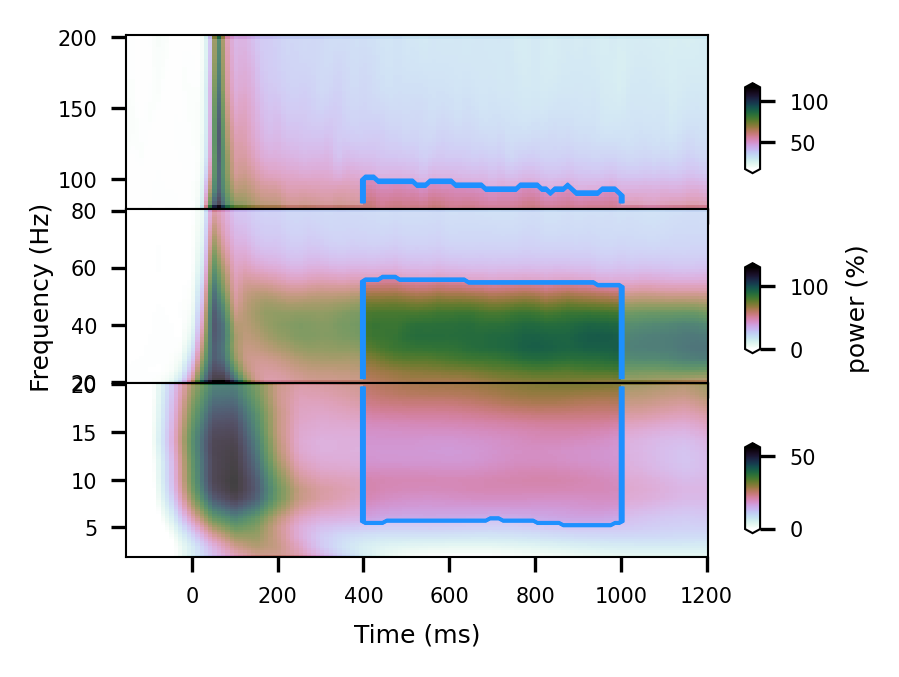

stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_grat_spw_500_minmax.npz
tfr emp  :  (30, 12, 19, 57)
tfr null   : (500, 30, 12, 19, 2)
peak frequency range :  16.0
power average within peak: 59.503313756810016
min-max
For k=0.5, the point in the range 28.454587055887803-167.8297505539238 is: 98.1421688049058
cutoff computed using min/max of null distribution:  -9.599872212238019
cutoff computed using min/max of null distribution:  52.76163922059745
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_grat_spw_500_minmax.npz


/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:377: RuntimeWarning: Mean of empty slice
  tfr_emp_ = np.squeeze(np.nanmean(tfr_emp,axis=0))
/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:378: RuntimeWarning: Mean of empty slice
  gavg = np.squeeze(np.nanmean(tfr_emp_,axis=0))
/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:423: RuntimeWarning: Mean of empty slice
  davg = np.squeeze(np.nanmean(tfr_emp[:,:,pk-2*sigma:pk,:],axis=0))
/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:540: UserWarning: No contour levels were found within the data range.
  ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],


tfr emp  :  (30, 12, 16, 113)
tfr null   : (500, 30, 12, 16, 2)
peak frequency range :  28.0 44.0
power average within peak: 86.6390137791448
min-max
For k=0.5, the point in the range 5.461788075450022-157.32076719625982 is: 81.39127763585492
cutoff computed using min/max of null distribution:  -17.739726357470396
cutoff computed using min/max of null distribution:  53.25284675735072
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_higher_grat_spw_500_minmax.npz
tfr emp  :  (30, 12, 11, 141)


/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:434: RuntimeWarning: Mean of empty slice
  davg = np.squeeze(np.nanmean(tfr_emp[:,:,pk-sigma:pk+sigma,:],axis=0))


tfr null   : (500, 30, 12, 11, 2)
peak frequency range :  128.0
power average within peak: 17.280991024867717
min-max
For k=0.5, the point in the range -1.701883932392761-69.00914486182131 is: 33.653630464714276
cutoff computed using min/max of null distribution:  -11.780574549869606
cutoff computed using min/max of null distribution:  19.454694273132354


/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:413: RuntimeWarning: Mean of empty slice
  davg = np.squeeze(np.nanmean(tfr_emp[:,:,pk:pk+2*sigma,:],axis=0))


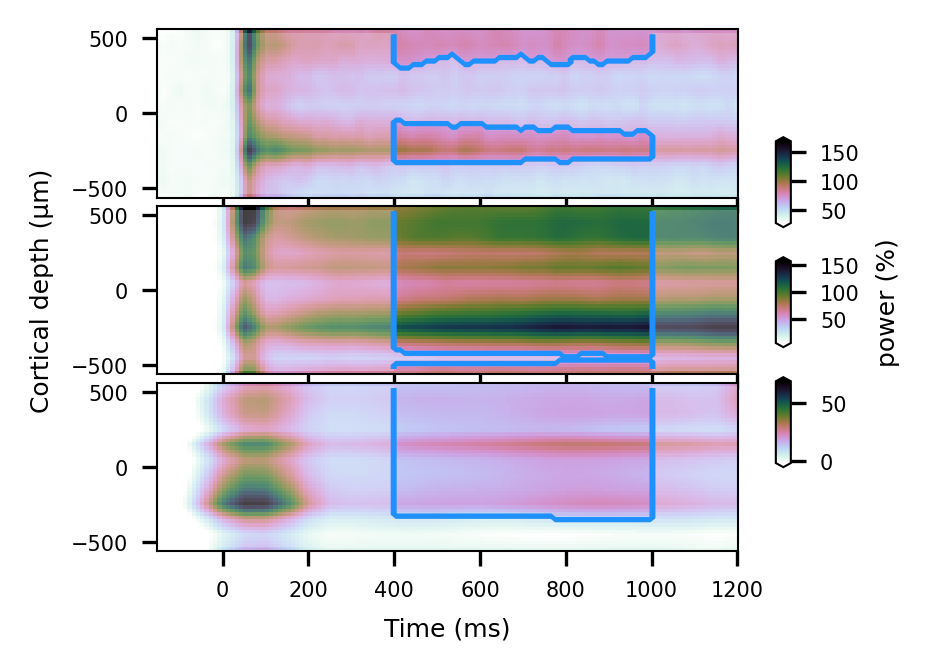

/Volumes/Gandalf/MWlamprop/results/figures/univariate/uv_tfr_depth_grat_spw_97.5_0_1000.png
nat bck-obj
Sites x sessions:  (12, 11)
Site indices:  [[  0  12  24  36  48  60  72  84  96 108 120]
 [  1  13  25  37  49  61  73  85  97 109 121]
 [  2  14  26  38  50  62  74  86  98 110 122]
 [  3  15  27  39  51  63  75  87  99 111 123]
 [  4  16  28  40  52  64  76  88 100 112 124]
 [  5  17  29  41  53  65  77  89 101 113 125]
 [  6  18  30  42  54  66  78  90 102 114 126]
 [  7  19  31  43  55  67  79  91 103 115 127]
 [  8  20  32  44  56  68  80  92 104 116 128]
 [  9  21  33  45  57  69  81  93 105 117 129]
 [ 10  22  34  46  58  70  82  94 106 118 130]
 [ 11  23  35  47  59  71  83  95 107 119 131]]
Depth indices:  [  0  12  24  36  48  60  72  84  96 108 120]
Load data
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_nat_spw_500_minmax.npz
tfr emp  :  (36, 12, 19, 57)
tfr null   : (500, 36, 12, 19, 2)
Plot results
shape emp  : (36, 12, 19, 57)
shape null 

/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:255: UserWarning: No contour levels were found within the data range.
  ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],


/Volumes/Gandalf/MWlamprop/results/figures/univariate/uv_tfr_freq_bck-obj_spw_across_97.5_0_1000.png


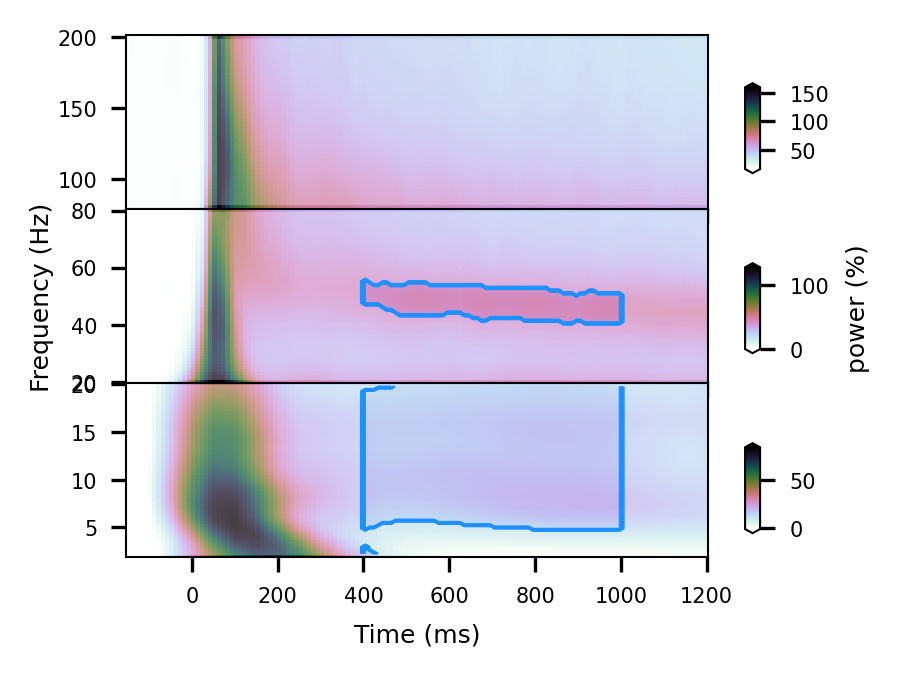

stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_nat_spw_500_minmax.npz
tfr emp  :  (36, 12, 19, 57)
tfr null   : (500, 36, 12, 19, 2)
peak frequency range :  7.0 11.0
power average within peak: 48.72408550213469
min-max
For k=0.5, the point in the range 10.556336189686366-311.21502604606457 is: 160.88568111787546
cutoff computed using min/max of null distribution:  -7.117509899157181
cutoff computed using min/max of null distribution:  41.27021542759884
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_nat_spw_500_minmax.npz
tfr emp  :  (36, 12, 16, 113)
tfr null   : (500, 36, 12, 16, 2)
peak frequency range :  40.0 56.0
power average within peak: 42.30210196950297
min-max
For k=0.5, the point in the range 0.8756232633192201-312.33170759682434 is: 156.6036654300718
cutoff computed using min/max of null distribution:  -10.227569538464586
cutoff computed using min/max of null distribution:  47.33867201469017
stats : /Volumes/Gandalf/

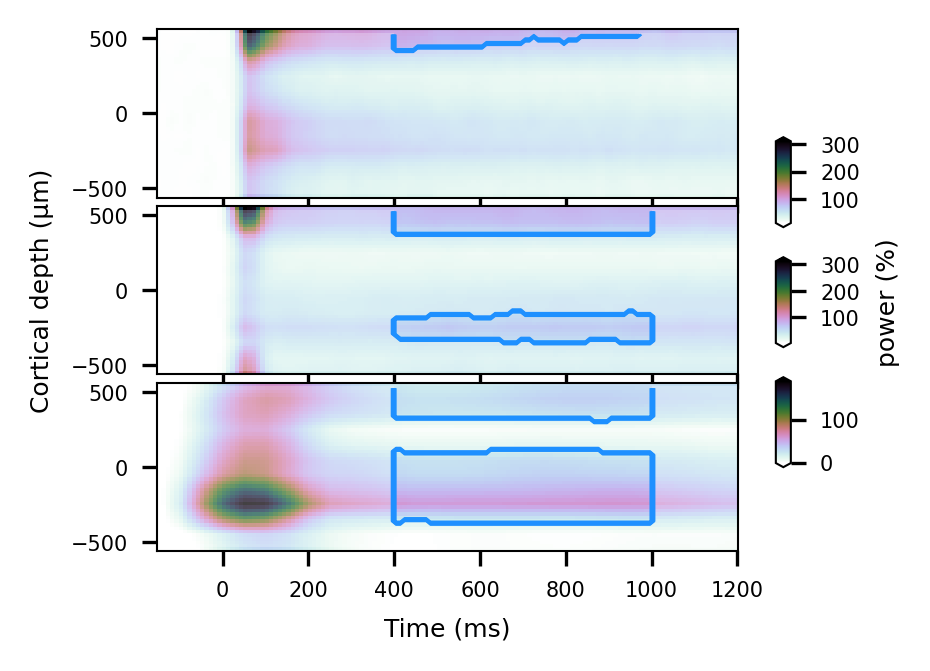

/Volumes/Gandalf/MWlamprop/results/figures/univariate/uv_tfr_depth_bck-obj_spw_97.5_0_1000.png
nat bck
Sites x sessions:  (12, 11)
Site indices:  [[  0  12  24  36  48  60  72  84  96 108 120]
 [  1  13  25  37  49  61  73  85  97 109 121]
 [  2  14  26  38  50  62  74  86  98 110 122]
 [  3  15  27  39  51  63  75  87  99 111 123]
 [  4  16  28  40  52  64  76  88 100 112 124]
 [  5  17  29  41  53  65  77  89 101 113 125]
 [  6  18  30  42  54  66  78  90 102 114 126]
 [  7  19  31  43  55  67  79  91 103 115 127]
 [  8  20  32  44  56  68  80  92 104 116 128]
 [  9  21  33  45  57  69  81  93 105 117 129]
 [ 10  22  34  46  58  70  82  94 106 118 130]
 [ 11  23  35  47  59  71  83  95 107 119 131]]
Depth indices:  [  0  12  24  36  48  60  72  84  96 108 120]
Load data
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_nat_spw_500_minmax.npz
tfr emp  :  (18, 12, 19, 57)
tfr null   : (500, 18, 12, 19, 2)
Plot results
shape emp  : (18, 12, 19, 57)
shape null :

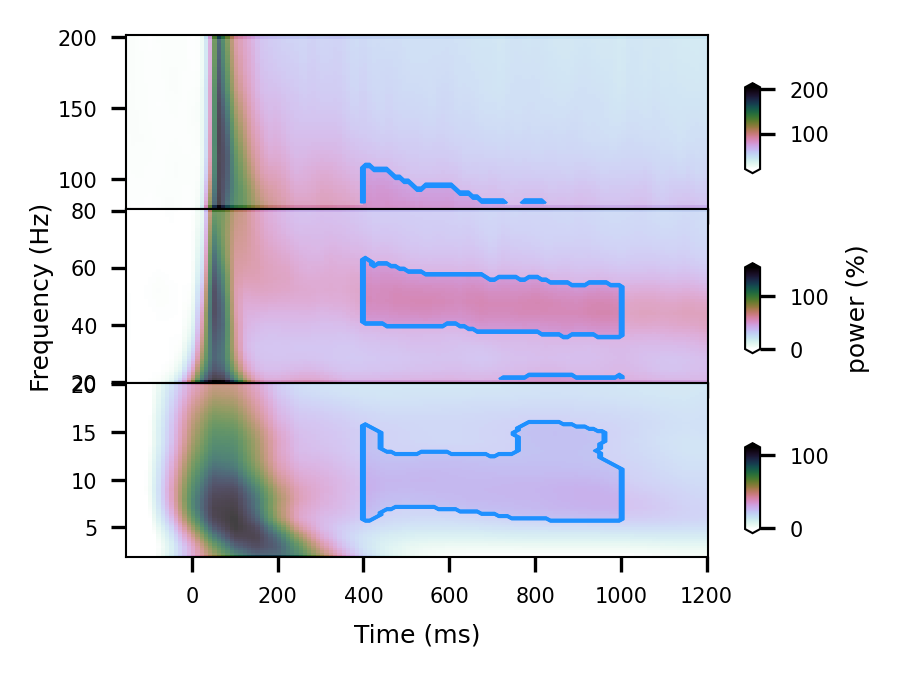

stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_nat_spw_500_minmax.npz
tfr emp  :  (18, 12, 19, 57)
tfr null   : (500, 18, 12, 19, 2)
peak frequency range :  7.0 11.0
power average within peak: 64.2782373854334
min-max
For k=0.5, the point in the range 13.19454518820915-392.6130844024455 is: 202.90381479532735
cutoff computed using min/max of null distribution:  -6.519950666196877
cutoff computed using min/max of null distribution:  61.01338245920163
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_nat_spw_500_minmax.npz
tfr emp  :  (18, 12, 16, 113)
tfr null   : (500, 18, 12, 16, 2)
peak frequency range :  40.0 56.0
power average within peak: 52.13592015910572
min-max
For k=0.5, the point in the range 0.620564317077168-392.3054282414331 is: 196.46299627925512
cutoff computed using min/max of null distribution:  -9.906855660998795
cutoff computed using min/max of null distribution:  51.921367349741054
stats : /Volumes/Gandalf/MWla

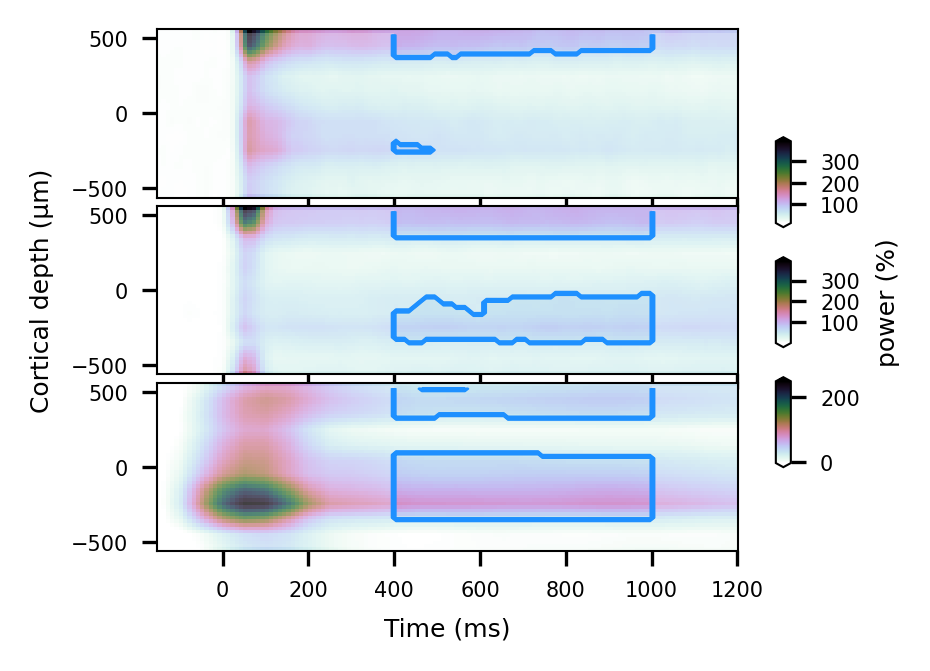

/Volumes/Gandalf/MWlamprop/results/figures/univariate/uv_tfr_depth_bck_spw_97.5_0_1000.png
nat obj
Sites x sessions:  (12, 11)
Site indices:  [[  0  12  24  36  48  60  72  84  96 108 120]
 [  1  13  25  37  49  61  73  85  97 109 121]
 [  2  14  26  38  50  62  74  86  98 110 122]
 [  3  15  27  39  51  63  75  87  99 111 123]
 [  4  16  28  40  52  64  76  88 100 112 124]
 [  5  17  29  41  53  65  77  89 101 113 125]
 [  6  18  30  42  54  66  78  90 102 114 126]
 [  7  19  31  43  55  67  79  91 103 115 127]
 [  8  20  32  44  56  68  80  92 104 116 128]
 [  9  21  33  45  57  69  81  93 105 117 129]
 [ 10  22  34  46  58  70  82  94 106 118 130]
 [ 11  23  35  47  59  71  83  95 107 119 131]]
Depth indices:  [  0  12  24  36  48  60  72  84  96 108 120]
Load data
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_nat_spw_500_minmax.npz
tfr emp  :  (18, 12, 19, 57)
tfr null   : (500, 18, 12, 19, 2)
Plot results
shape emp  : (18, 12, 19, 57)
shape null : (50

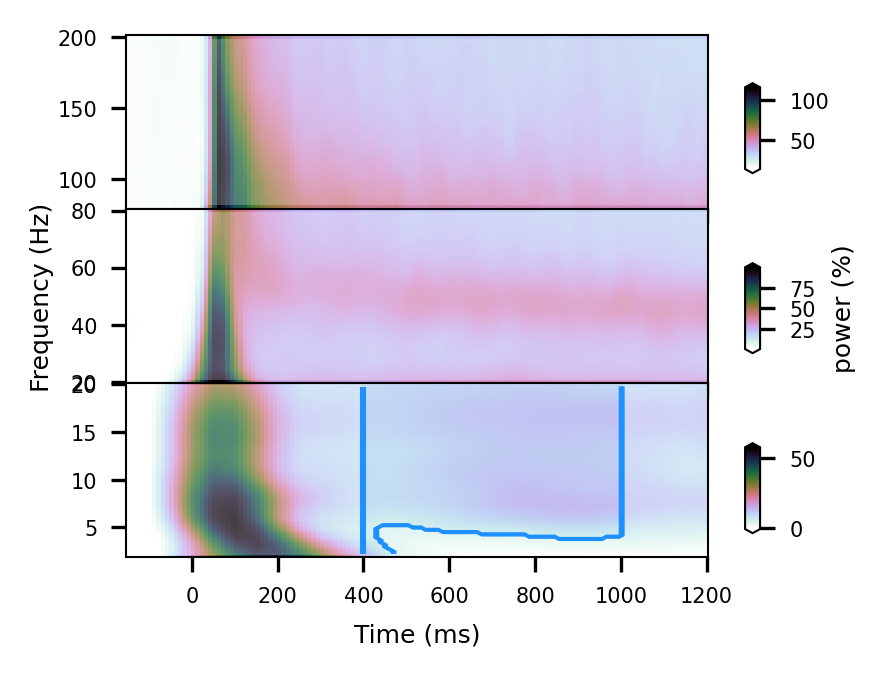

stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_low_nat_spw_500_minmax.npz
tfr emp  :  (18, 12, 19, 57)
tfr null   : (500, 18, 12, 19, 2)
peak frequency range :  15.0 19.0
power average within peak: 33.76095131590588
min-max
For k=0.5, the point in the range 12.3366740068419-168.21230508008122 is: 90.27448954346157
cutoff computed using min/max of null distribution:  -6.83294990285604
cutoff computed using min/max of null distribution:  26.667348285752624
stats : /Volumes/Gandalf/MWlamprop/results/stats/univariate/uvtfr_stats_high_nat_spw_500_minmax.npz
tfr emp  :  (18, 12, 16, 113)
tfr null   : (500, 18, 12, 16, 2)
peak frequency range :  40.0 56.0
power average within peak: 32.468283779900226
min-max
For k=0.5, the point in the range 0.3597851959615941-232.35798695221555 is: 116.35888607408857
cutoff computed using min/max of null distribution:  -9.840437787375391
cutoff computed using min/max of null distribution:  45.57788391918248
stats : /Volumes/Gandalf/M

/var/folders/_n/cg8c3_pj1_778vx80m_y0nww0000gn/T/ipykernel_87051/1667485046.py:526: UserWarning: No contour levels were found within the data range.
  ax[panel[fband]].contour(X2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]], Y2[overlay_range[0]:overlay_range[1],twindow[0]:-twindow[1]],


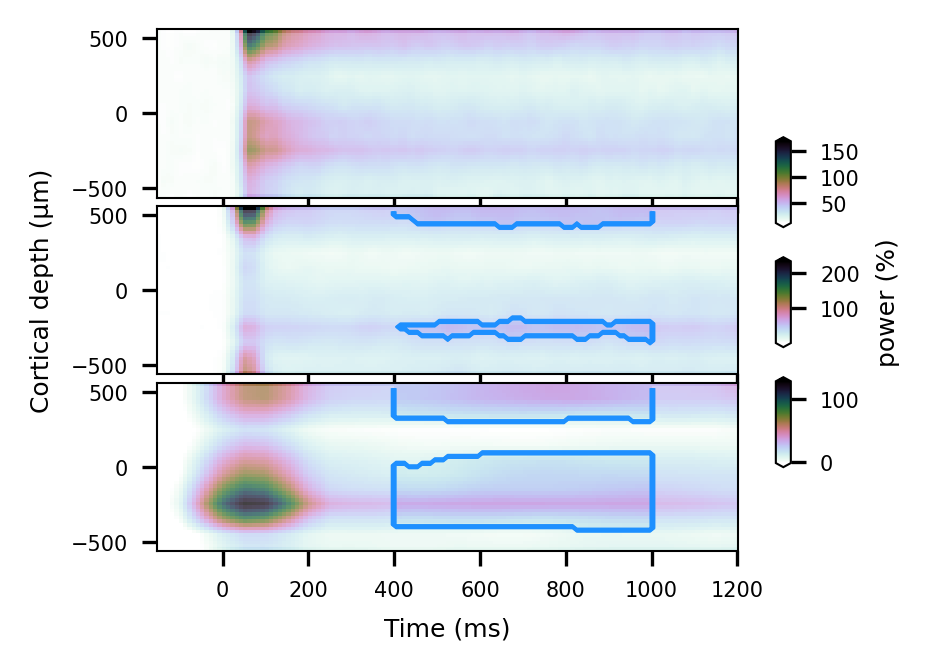

/Volumes/Gandalf/MWlamprop/results/figures/univariate/uv_tfr_depth_obj_spw_97.5_0_1000.png


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import matplotlib.colors as colors
import statsmodels.api as sm

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 0.5  


path =  '/Users/nicogravel/Documents/Gandalf/MWlamprop/code/notebooks/'
path =  '/Users/nicogravel/Documents/Gandalf/MWlamprop/lamidec/'
input_path = '/Users/nicogravel/Documents/Gandalf/MWlamprop/data/results_bckp/' #'/Users/nicogravel/Documents/Gandalf/MWlamprop/lamidec/'
#input_path = '/Users/nicogravel/Documents/Websites/MWlamprop_Elena/results/stats/univariate/' # '/Volumes/Gandalf/stats/'
input_path = '/Volumes/Gandalf/MWlamprop/results/stats/univariate/' # '/Volumes/Gandalf/stats/'
figure_path = '/Users/nicogravel/Documents/Gandalf/MWlamprop/results/'
figure_path = '/Users/nicogravel/Documents/Websites/presentation/reports/figures/nw/'
figure_path = '/Volumes/Gandalf/MWlamprop/results/figures/univariate/'
#figure_path = '/Users/nicogravel/Documents/Websites/MWlamprop/results/figures/univariate/'


fbands  = ['lf','hf','hhf','mua']
fbands  = ['low','high','higher','mua']
#fbands  = ['lf','hf','higher','mua']

blocks  = ['grat', 'nat','nat','nat','nat','nat']
conds   = ['grat', 'obj', 'bck','grat_lowcon','grat_highcon','bckXobj']
tests   = ['','_b','_depth','_sess'] 

for cond in range(4):

    conf = {
    'paths'    : [
        input_path,
        #'/Users/nicogravel/ocuments/Gandalf/MWlamprop/data/processed/spectral_dec/' 
        #'/Users/nicogravel/Documents/Gandalf/MWlamprop/data/processed/',
        #'/Users/nicogravel/Documents/Gandalf/MWlamprop/data/results_bckp/',
        figure_path,
        figure_path
        ],
    'decvars'  : ['spw','gpr','spwgpr'],
    'dvar'     : 0,
    'cond'     : cond,
    'sess'     : 0,   
    'coloffset': [0.5,1,1,1],  # a number between 0-1: [center, theta max, gamma max, hf broadband max] 
    'stats'    : 4,
    'null'     : 1,
    'n_perm'   : 0,
    'cutoff'   : True, 
    'prctl'    : 97.5, 
    'p_val'    : 0.0001, 
    'cmap'     : 'cubehelix_r',
    'compute_tfrs'     : True,
    'twindow'    : [65, 80],
    'cnorm_range' : [0, 1000], #[-200, 1200], #[400, 1000], #[350, 1200],
    'tclust'    : [70, 75], #[350, 1200],
    'test'    : 0,
    'alpha'   : 0.05,
    'cnorm'   : 0,
    'max_pwr'   : 150,
    'img_type' : '.png'

    }

    type         = 'minmax'
    plot_uvtfr(conf, type)